# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

# Neural network 
Simple one layer neural network classifier. Mathjax formula not fully supported in github, hence the formulas get corrupted.

<img src="image/nn_diagram.png" align="left">

<img src="image/nn_functions.png" align="left">

# Setup

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple
)

## Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

## Package dependencies

In [3]:
from typing import (
    Union,
    List,
    Callable
)
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

## Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# %matplotlib notebook
%matplotlib inline

## Network geometry

In [5]:
N = 1    # Batch size
D = 3    # Number of features in the input data
M = 2    # Number of nodes in a layer

---

# Confiurations 

## X
X is to have been standardized. 

## T
Labels for data X.

### For One Hot Encoding labels
$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \; \dots \;, \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (N,M) }{ T_{_{OHE}} } = ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### For index labels
$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \qquad \text {for index labels }
\end{align*}
$

## W
Weight parameters.

In [6]:
from common import (
    xavier,
    he,
    uniform
)

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from layer.matmul import Matmul

## Objective Function
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

## Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Objective function
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == float), \
        "X must be float or ndarray(dtype=float)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - C)
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Objective function
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

### Gradient from cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


###  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [9]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [11]:
dJ = np.ones(N) / N
dJ

array([1.])

---


# Gradient check

* [two_layer_net.ipynb defines the lambda with parameter W which is redundant #254](https://github.com/cs231n/cs231n.github.io/issues/254)

The ```numerical_jacobian(f, X)``` returns ```J``` of the same shape with ```X```. It takes each element in ```x``` in ```X```, and calculate ```(f(x+h) and f(x-h))/2h```. For ```cross_entropy_logg_loss()```, the expected numerical gradient is ```gn = (-np.log(p+h+e) + -np.log(p-h+e)) / (2*h)``` for each element ```p``` in ```P```. 

In [12]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: float = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that has the same sh

In [13]:
# --------------------------------------------------------------------------------
# Example gradients for the cross entropy log loss -t*log(p).
# --------------------------------------------------------------------------------
p =0.86270721
h = OFFSET_DELTA
e = OFFSET_LOG

expected_gn = (-np.log(p+h+e) + np.log(p-h+e)) / (2*h)
actual_gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
print(f"Expected numerical gradient={expected_gn}")
print(f"Actual numerical gradient={actual_gn}")
print(f"Expected analytical gradient -T/P={-1 / (p+e)}")

Expected numerical gradient=-1.1591418103140683
Actual numerical gradient=[-1.15914181]
Expected analytical gradient -T/P=-1.1591418122503674


In [14]:
p = 0.50924298 
gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
gn

array([-1.9636992])

---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [15]:
from common import (
    weights,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network.test_020_one_layer_classifier import (
    train_classifier
)
from drawing import (
    COLOR_LABELS,
    plot_categorical_predictions
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
Logger = logging.getLogger("train_classifier")
Logger.setLevel(logging.INFO)

In [16]:
np.set_printoptions(threshold=sys.maxsize)
%matplotlib notebook

def draw_training(X, W, _ax=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [17]:
N = 500    # Number of plots
D = 3      # Number of features
from data.classifications import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
ax.scatter(X[T==1, 1], X[T==1, 2], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

<IPython.core.display.Javascript object>

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

<IPython.core.display.Javascript object>


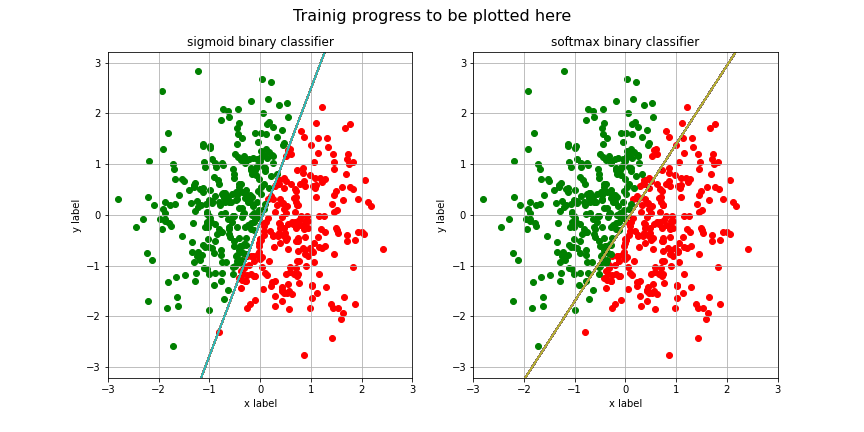

Text(0.5, 1.0, 'softmax binary classifier')

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
for i in range(2):
    ax[i].scatter(X[T==0, 1], X[T==0, 2], c='red')
    ax[i].scatter(X[T==1, 1], X[T==1, 2], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress to be plotted here', fontsize=16)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")

## Sigmoid classifier training

Plots in the previous cell.

In [20]:
print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 1
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    callback=draw
)

Train a sigmoid classifier to find optimal W (0.028364705525152984, -0.9288287958125055, 0.36942186122367227) for the boundary.
0.9679390352799659
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[0]. Loss is [0.9679390352799659]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.36450827  0.29825077 -0.47574891]]
0.9402614944284249
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[1]. Loss is [0.9402614944284249]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.35229591  0.25490445 -0.45002726]]
0.9136607126727779
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[2]. Loss is [0.9136607126727779]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.34030553  0.21246501 -0.42477494]]
0.8881267357304475
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[3]. Loss is [0.8881267357304475]
INFO:networ

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.0838306  -0.71862535  0.1320217 ]]
0.4753520011441584
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[34]. Loss is [0.4753520011441584]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.07866504 -0.73963993  0.14417873]]
0.46925468585199304
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[35]. Loss is [0.46925468585199304]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.07363811 -0.76028803  0.15608516]]
0.4633812117985619
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[36]. Loss is [0.4633812117985619]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.06874522 -0.78058266  0.16774947]]
0.4577197561057403
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[37]. Loss is [0.4577197561057403]
INFO:network.test_020_one_layer_classi

INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.0353717  -1.28416625  0.44320811]]
0.34702557019241315
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[68]. Loss is [0.34702557019241315]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.03764485 -1.29748023  0.4501022 ]]
0.3447408816795281
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[69]. Loss is [0.3447408816795281]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.03987044 -1.31065973  0.45690678]]
0.34250573616999974
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[70]. Loss is [0.34250573616999974]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.04204978 -1.32370785  0.46362408]]
0.34031842233681625
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[71]. Loss is [0.34031842233681625]
INFO:network.test_020_one_layer_cl

array([[ 0.08973601, -1.65576604,  0.62831226]])

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [21]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 200

M = 2                      
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    callback=draw
)

Train a softmax classifier to find optimal W (0.028364705525152984, -0.9288287958125055, 0.36942186122367227) for the boundary.
0.32530975689514574
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[0]. Loss is [0.32530975689514574]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.11931984  0.99376299 -0.9832857 ]
 [-0.34112577 -0.62745273 -0.16342743]]
0.3202150116093546
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[1]. Loss is [0.3202150116093546]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.10926571  1.0054928  -0.98565355]
 [-0.33107164 -0.63918254 -0.16105958]]
0.31540172749436124
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[2]. Loss is [0.31540172749436124]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.0995947   1.01697997 -0.98800716]
 [-0.32140064 -0.65066971 -0.15870597]]
0.31084816807663046
INFO:network.t

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.06030236  1.25734476 -1.04626576]
 [-0.16150357 -0.89103449 -0.10044737]]
0.24300967083677893
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[29]. Loss is [0.24300967083677893]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.06407902  1.26501904 -1.04841767]
 [-0.15772691 -0.89870877 -0.09829546]]
0.24146645082143267
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[30]. Loss is [0.24146645082143267]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.06773869  1.2726096  -1.05056309]
 [-0.15406724 -0.90629934 -0.09615004]]
0.23996615921250336
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[31]. Loss is [0.23996615921250336]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.07128569  1.28011879 -1.05270198]
 [-0.15052024 -0.91380852 -0.09401115]]
0.2385066958737766
INFO

0.21032251885353367
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[58]. Loss is [0.21032251885353367]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.13621488  1.45842495 -1.10784627]
 [-0.08559106 -1.09211469 -0.03886686]]
0.20949720278312794
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[59]. Loss is [0.20949720278312794]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.13779955  1.46429995 -1.10978903]
 [-0.08400639 -1.09798969 -0.0369241 ]]
0.20868529028389451
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[60]. Loss is [0.20868529028389451]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.13934261  1.47013249 -1.11172461]
 [-0.08246332 -1.10382222 -0.03498852]]
0.20788636893109214
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[61]. Loss is [0.20788636893109214]
INFO:netwo

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.16908732  1.61391014 -1.16132128]
 [-0.05271861 -1.24759987  0.01460815]]
0.19011135862206885
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[88]. Loss is [0.19011135862206885]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.16985701  1.61879947 -1.16306251]
 [-0.05194892 -1.25248921  0.01634939]]
0.18956287639024103
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[89]. Loss is [0.18956287639024103]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.17060904  1.62366191 -1.16479718]
 [-0.0511969  -1.25735164  0.01808405]]
0.18902059425275308
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[90]. Loss is [0.18902059425275308]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.17134388  1.62849782 -1.16652532]
 [-0.05046206 -1.26218756  0.01981219]]
0.18848438339690907
INF

0.17633154338431137
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[117]. Loss is [0.17633154338431137]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.18610464  1.75018477 -1.21083408]
 [-0.0357013  -1.3838745   0.06412095]]
0.175922179695422
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[118]. Loss is [0.175922179695422]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.18650518  1.75439925 -1.21239263]
 [-0.03530075 -1.38808898  0.0656795 ]]
0.17551646378962202
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[119]. Loss is [0.17551646378962202]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.18689768  1.75859509 -1.21394562]
 [-0.03490825 -1.39228483  0.06723249]]
0.17511433802356732
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[120]. Loss is [0.17511433802356732]
INFO:netwo

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.19506347  1.86550622 -1.25389118]
 [-0.02674246 -1.49919596  0.10717805]]
0.1654353018768457
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[147]. Loss is [0.1654353018768457]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.19529431  1.86925157 -1.2553014 ]
 [-0.02651163 -1.50294131  0.10858827]]
0.16511482668504518
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[148]. Loss is [0.16511482668504518]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.1955211   1.87298299 -1.25670697]
 [-0.02628483 -1.50667273  0.10999384]]
0.16479672247432756
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[149]. Loss is [0.16479672247432756]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.19574395  1.87670062 -1.25810792]
 [-0.02606198 -1.51039035  0.11139479]]
0.16448095875998583
IN

0.15700477942758806
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[176]. Loss is [0.15700477942758806]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.2005456   1.97228109 -1.29428734]
 [-0.02126034 -1.60597083  0.14757421]]
0.15674247556846058
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[177]. Loss is [0.15674247556846058]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.20068696  1.97565753 -1.29556992]
 [-0.02111898 -1.60934726  0.14885679]]
0.15648184680040245
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[178]. Loss is [0.15648184680040245]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.20082622  1.97902318 -1.29684863]
 [-0.02097971 -1.61271292  0.1501355 ]]
0.15622287468192128
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[179]. Loss is [0.15622287468192128]
INFO:n

array([[-0.20333453,  2.04735345, -1.32285064],
       [-0.01847141, -1.68104319,  0.17613751]])

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [22]:
from common import (
    prediction_grid
)
from data import (
    linear_separable_sectors,
    spiral
)

## Linearly separable multiple categories

### Data X and Label T
Training data to lassify into M categories and labels T.

In [23]:
print(f"Train a categorical classifier")
MAX_TEST_TIMES = 200
N = 150
D = 3      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

In [24]:
# Radius of a circle within which to place plots.
radius = 2   

# labels to classify outside/0/red or inside/1/green.
labels=COLOR_LABELS

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,5)) 
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
#  Classify plots (x, y) if inside the coverage sector
# --------------------------------------------------------------------------------
Y = labels[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,1], X[::,2], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), labels[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

<IPython.core.display.Javascript object>

Text(0.5, 0.98, 'Categorical classifiation data')

### Train on linearly separable multiple categories

In [25]:
W = weights.he(M, D)
optimizer = SGD(lr=0.1)

W = train_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES
)

0.9891023151766759
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[0]. Loss is [0.9891023151766759]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.35824884  0.62384325  0.52715525]
 [-0.37192526 -0.95511497 -0.80259523]
 [-0.30890142 -0.3578001  -0.42781266]]
0.9714393030880503
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[1]. Loss is [0.9714393030880503]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.33864575  0.60962926  0.53903943]
 [-0.36202601 -0.96564809 -0.80914558]
 [-0.29919758 -0.33305299 -0.43314649]]
0.954486117776695
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[2]. Loss is [0.954486117776695]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.31965356  0.59564084  0.55073977]
 [-0.35250355 -0.97604471 -0.81558108]
 [-0.28972785 -0.30866795 -0.43841134]]
0.9382149031162559
INFO:network.test_020_one_layer_

INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.01997305  0.33730399  0.78293498]
 [-0.20667505 -1.1834768  -0.94307604]
 [-0.13587583  0.15710099 -0.54311159]]
0.7000154964221078
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[26]. Loss is [0.7000154964221078]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.01162268  0.3286487   0.79186133]
 [-0.20249213 -1.19132517 -0.94802943]
 [-0.13170839  0.17360465 -0.54708455]]
0.6937436652924
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[27]. Loss is [0.6937436652924]
INFO:network.test_020_one_layer_classifier:W after is 
[[ 0.0035654   0.32017936  0.80071588]
 [-0.19842721 -1.19909093 -0.95294789]
 [-0.12771602  0.18983975 -0.55102064]]
0.6876927822187681
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[28]. Loss is [0.6876927822187681]
INFO:network.test_020_one_layer_classifier:W after i

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.1240747   0.16199802  0.99579818]
 [-0.12625877 -1.36460754 -1.06197846]
 [-0.07224438  0.5135377  -0.63707237]]
0.5875356455735705
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[52]. Loss is [0.5875356455735705]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.1273948   0.15688995  1.00332195]
 [-0.12401271 -1.37078042 -1.06618411]
 [-0.07117033  0.52481864 -0.64039049]]
0.584615592070259
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[53]. Loss is [0.584615592070259]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.13060129  0.15187391  1.01080426]
 [-0.12181066 -1.37690552 -1.0703649 ]
 [-0.07016589  0.53595978 -0.64369201]]
0.5817615630809843
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[54]. Loss is [0.5817615630809843]
INFO:network.test_020_one_layer_classifier:W aft

0.5334028460789223
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[75]. Loss is [0.5334028460789223]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.17921865  0.0605275   1.16591368]
 [-0.08220785 -1.50132347 -1.1564352 ]
 [-0.06115133  0.75172415 -0.71273114]]
[[ 0.01457097  0.03443897 -0.06649604]
 [-0.01478667  0.0524811   0.03657165]
 [ 0.0002157  -0.08692007  0.02992438]]
Diff
[[-0.00050222 -0.0005113   0.00031744]
 [ 0.00022752 -0.00030492 -0.00020563]
 [ 0.0002747   0.00081622 -0.0001118 ]]
0.5315207169149253
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[76]. Loss is [0.5315207169149253]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.18067721  0.05708015  1.17256994]
 [-0.08072771 -1.50657683 -1.16009602]
 [-0.06117292  0.76042485 -0.71572657]]
[[ 0.01408567  0.03393948 -0.06618175]
 [-0.01456491  0.05218153  0.03636783]
 [ 0.00047923 -0.08612101  0.02981391]]
Diff


0.49768381433198783
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[97]. Loss is [0.49768381433198783]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.20222104 -0.0053067   1.30552751]
 [-0.05403014 -1.61068303 -1.23253424]
 [-0.06632666  0.92691791 -0.77624592]]
0.4962940540402032
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[98]. Loss is [0.4962940540402032]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.20291155 -0.00787363  1.31155644]
 [-0.05293304 -1.61537871 -1.23578694]
 [-0.06673325  0.93418052 -0.77902215]]
0.4949208731753076
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[99]. Loss is [0.4949208731753076]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.20357867 -0.0104094   1.31755978]
 [-0.05184918 -1.62005326 -1.23902305]
 [-0.06714999  0.94139084 -0.78178938]]
0.49356390168001657
INFO:network.test_020_on

0.46612996787373995
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[123]. Loss is [0.46612996787373995]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21418664 -0.06329598  1.45451961]
 [-0.02916799 -1.72658213 -1.31211032]
 [-0.0792232   1.10080629 -0.84566195]]
0.465076436690739
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[124]. Loss is [0.465076436690739]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21445721 -0.06521594  1.45995116]
 [-0.02833963 -1.73080934 -1.3149805 ]
 [-0.07978099  1.10695345 -0.84822332]]
0.46403279247267826
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[125]. Loss is [0.46403279247267826]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21471749 -0.0671165   1.4653623 ]
 [-0.02751912 -1.7350213  -1.31783784]
 [-0.08034122  1.11306597 -0.85077711]]
0.4629988642800974
INFO:network.test_020_

0.4415639624620415
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[149]. Loss is [0.4415639624620415]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21856263 -0.10764966  1.58952538]
 [-0.00985815 -1.83192368 -1.38287194]
 [-0.09415706  1.25050152 -0.9099061 ]]
0.44072145357578885
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[150]. Loss is [0.44072145357578885]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21864599 -0.10915363  1.59447737]
 [-0.00919533 -1.83580118 -1.38544602]
 [-0.09473651  1.25588299 -0.912284  ]]
0.43988550035179474
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[151]. Loss is [0.43988550035179474]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21872471 -0.11064467  1.59941285]
 [-0.00853757 -1.83966688 -1.38801014]
 [-0.09531556  1.26123973 -0.91465536]]
0.43905600989200444
INFO:network.test_0

0.4229836138575732
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[173]. Loss is [0.4229836138575732]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21952386 -0.14051674  1.70406236]
 [ 0.00479597 -1.92191834 -1.44207678]
 [-0.10784994  1.37336325 -0.96523823]]
[[ 3.12463928e-05  1.23721290e-02 -4.58404112e-02]
 [-5.59453570e-03  3.61598921e-02  2.35623147e-02]
 [ 5.56328930e-03 -4.85320211e-02  2.22780965e-02]]
Diff
[[-2.29186532e-05 -9.41980121e-05  1.38558667e-04]
 [ 3.61940701e-05 -9.79420092e-05 -8.06157023e-05]
 [-1.32754170e-05  1.92140021e-04 -5.79429649e-05]]
0.4222762208209714
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[174]. Loss is [0.4222762208209714]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21952699 -0.14175519  1.70865098]
 [ 0.00535598 -1.92553794 -1.44443537]
 [-0.10840683  1.37822131 -0.96746827]]
[[ 9.03121546e-06  1.22791464e-02 -4.57028613e-02

0.4103060404320314
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[192]. Loss is [0.4103060404320314]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21926234 -0.16256405  1.78898473]
 [ 0.01486727 -1.98909198 -1.48558755]
 [-0.11818276  1.4625842  -1.00664983]]
0.40968023126981246
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[193]. Loss is [0.40968023126981246]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21923322 -0.16364426  1.79332788]
 [ 0.01536661 -1.99253795 -1.48780548]
 [-0.11871122  1.46711039 -1.00877505]]
0.4090582423344495
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[194]. Loss is [0.4090582423344495]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.21920289 -0.16471713  1.79765899]
 [ 0.01586313 -1.99597539 -1.49001661]
 [-0.11923807  1.4716207  -1.01089503]]
0.40844003160678116
INFO:network.test_020

## Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


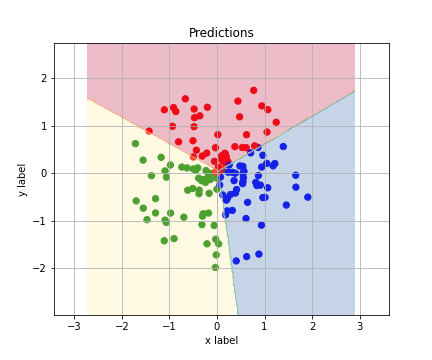

In [27]:
fig, ax = plt.subplots(figsize=(6,5)) 
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.grid()

ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

## Non-linear separable spiral data

<IPython.core.display.Javascript object>


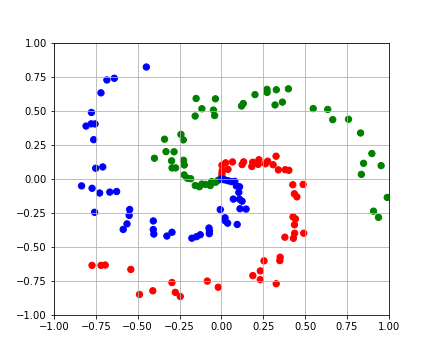

In [28]:
MAX_TEST_TIMES = 200
M = 3        # Number of category classes
K = 50       # Number of data points per class
N = M * K    # Number of entire data points
D = 3        # Dimensions inluding bias


# X[::,0] is bias
X, T = spiral(K, D, M)

# Y is colors as labels, instead of category indices.
Y = labels[T]

fig, ax = plt.subplots(figsize=(6,5)) 
ax.scatter(X[:, 1], X[:, 2], c=Y, s=40)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.grid()

### Train on non-linear separable spiral data

In [29]:
W = weights.he(M, D)
optimizer = SGD(lr=0.1)

W = train_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES
)

1.1986143987442892
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[0]. Loss is [1.1986143987442892]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39883336 -0.43069427 -0.05337127]
 [-0.46633579 -0.17493512 -0.05628198]
 [-0.2734347   0.50142554 -0.07998989]]
1.1941939843016427
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[1]. Loss is [1.1941939843016427]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39837627 -0.4237946  -0.06140588]
 [-0.46318356 -0.16864486 -0.0469482 ]
 [-0.27704403  0.48823562 -0.08128905]]
1.189837270465828
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[2]. Loss is [1.189837270465828]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39794726 -0.41693775 -0.06940228]
 [-0.46013217 -0.16239386 -0.03765879]
 [-0.28052442  0.47512777 -0.08258205]]
1.1855427001088246
INFO:network.test_020_one_layer_

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39334265 -0.27024162 -0.24307991]
 [-0.41173978 -0.02910792  0.16385757]
 [-0.33352142  0.1951457  -0.11042079]]
1.101140011566584
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[26]. Loss is [1.101140011566584]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39328972 -0.26431058 -0.25020212]
 [-0.41036211 -0.02375096  0.17210303]
 [-0.33495202  0.18385769 -0.11154404]]
1.0980005590629114
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[27]. Loss is [1.0980005590629114]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39324402 -0.2584144  -0.2572901 ]
 [-0.4090297  -0.01842884  0.18030689]
 [-0.33633014  0.1726394  -0.11265992]]
1.0948990287784697
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[28]. Loss is [1.0948990287784697]
INFO:network.test_020_one_layer_classifier:W aft

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39319312 -0.16861621 -0.36620452]
 [-0.39277203  0.06216044  0.30609321]
 [-0.35263871  0.00225193 -0.12953182]]
1.0499806690038214
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[44]. Loss is [1.0499806690038214]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39321727 -0.16327572 -0.37274101]
 [-0.39201326  0.06692305  0.31362449]
 [-0.35337333 -0.00785118 -0.13052661]]
1.0474422319737657
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[45]. Loss is [1.0474422319737657]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39324321 -0.15796588 -0.37924686]
 [-0.39127882  0.07165472  0.32111835]
 [-0.35408183 -0.01789268 -0.13151463]]
1.044932774833413
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[46]. Loss is [1.044932774833413]
INFO:network.test_020_one_layer_classifier:W aft

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39405106 -0.03920588 -0.52669048]
 [-0.3791156   0.17648627  0.49037472]
 [-0.36543721 -0.24148424 -0.15332736]]
0.9924536566946872
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[70]. Loss is [0.9924536566946872]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39408231 -0.03459839 -0.53249159]
 [-0.37877535  0.1805133   0.4970114 ]
 [-0.3657462  -0.25011875 -0.15416294]]
0.9905546172547618
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[71]. Loss is [0.9905546172547618]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39411286 -0.0300166  -0.53826684]
 [-0.37844457  0.18451482  0.50361685]
 [-0.36604643 -0.25870206 -0.15499313]]
0.9886760540092913
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[72]. Loss is [0.9886760540092913]
INFO:network.test_020_one_layer_classifier:W a

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39458472  0.07267384 -0.66953313]
 [-0.37260285  0.27339417  0.65333176]
 [-0.37141629 -0.45027185 -0.17344176]]
0.949102241884516
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[96]. Loss is [0.949102241884516]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.3945928   0.07666699 -0.67471326]
 [-0.37242244  0.27681904  0.65922464]
 [-0.37158861 -0.45768987 -0.17415451]]
0.9476590724050182
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[97]. Loss is [0.9476590724050182]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39459999  0.08063862 -0.67987149]
 [-0.37224556  0.28022314  0.66509157]
 [-0.37175831 -0.4650656  -0.1748632 ]]
0.9462306231601182
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[98]. Loss is [0.9462306231601182]
INFO:network.test_020_one_layer_classifier:W aft

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39459585  0.14500357 -0.76433992]
 [-0.36966546  0.33507129  0.76103   ]
 [-0.37434254 -0.5842787  -0.1863332 ]]
0.9240319526673013
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[115]. Loss is [0.9240319526673013]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39458896  0.1486122  -0.76912639]
 [-0.36953334  0.33812871  0.76645955]
 [-0.37448155 -0.59094475 -0.18697628]]
0.9228396100059236
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[116]. Loss is [0.9228396100059236]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39458142  0.15220195 -0.77389339]
 [-0.36940291  0.34116829  0.77186635]
 [-0.37461953 -0.59757409 -0.1876161 ]]
0.9216589221427498
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[117]. Loss is [0.9216589221427498]
INFO:network.test_020_one_layer_classifier:

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39424719  0.23301581 -0.88274937]
 [-0.36664333  0.40911978  0.89518699]
 [-0.37771334 -0.74633944 -0.20208074]]
0.8964813245877139
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[141]. Loss is [0.8964813245877139]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39422848  0.23617337 -0.88706525]
 [-0.36653953  0.41175662  0.90007184]
 [-0.37783585 -0.75213383 -0.20264972]]
0.8955510443224082
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[142]. Loss is [0.8955510443224082]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39420951  0.23931512 -0.89136442]
 [-0.36643637  0.41437895  0.90493754]
 [-0.37795798 -0.75789792 -0.20321625]]
0.8946293308389494
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[143]. Loss is [0.8946293308389494]
INFO:network.test_020_one_layer_classifier:

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39370586  0.31024289 -0.98977228]
 [-0.36410815  0.47323767  1.01627013]
 [-0.38078985 -0.8876844  -0.21614098]]
0.8748409338834678
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[167]. Loss is [0.8748409338834678]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39368397  0.31302228 -0.99368326]
 [-0.36401595  0.47553114  1.02069403]
 [-0.38090394 -0.89275726 -0.2166539 ]]
0.8741045694993959
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[168]. Loss is [0.8741045694993959]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39366209  0.3157884  -0.99757983]
 [-0.36392406  0.47781272  1.02510164]
 [-0.38101771 -0.89780495 -0.21716494]]
0.8733745958715418
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[169]. Loss is [0.8733745958715418]
INFO:network.test_020_one_layer_classifier:

INFO:network.test_020_one_layer_classifier:W after is 
[[-0.3931556   0.37840795 -1.08696929]
 [-0.36179998  0.52922016  1.12623679]
 [-0.38364827 -1.01183195 -0.22891063]]
0.857603859533715
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[193]. Loss is [0.857603859533715]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39313588  0.38086867 -1.09052975]
 [-0.36171456  0.53123112  1.13026667]
 [-0.38375342 -1.01630364 -0.22938005]]
0.8570131583676289
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[194]. Loss is [0.8570131583676289]
INFO:network.test_020_one_layer_classifier:W after is 
[[-0.39311631  0.38331816 -1.09407768]
 [-0.36162937  0.53323225  1.13428254]
 [-0.38385819 -1.02075425 -0.22984799]]
0.8564272971553089
INFO:network.test_020_one_layer_classifier:network.test_020_one_layer_classifier: iteration[195]. Loss is [0.8564272971553089]
INFO:network.test_020_one_layer_classifier:W 

### Plot predictions

<IPython.core.display.Javascript object>


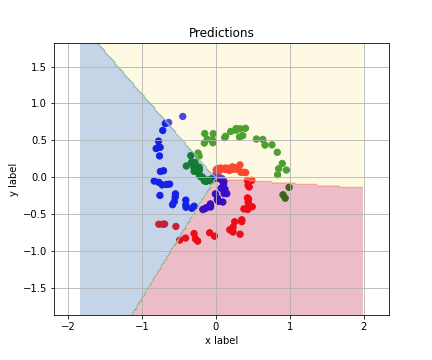

In [33]:
fig, ax = plt.subplots(figsize=(6,5)) 
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.grid()

ax.set_title("Predictions")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)